In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
import os
from PIL import Image
import pandas as pd
import random
from skimage import io
from shutil import copyfile
import sys
import time

### Load data from .csv files
Following files from Open Image dataset have been used:

* `train-images-boxable.csv` file contains the image name and image url
* `train-annotations-bbox.csv` file contains the bounding box info with the image id (name) and the image label name
* `class-descriptions-boxable.csv` file contains the image label name corresponding to its class name

The files can be found in:
https://storage.googleapis.com/openimages/web/download_v7.html

In [29]:
images_boxable_fname = './data/CSVs/Open_Image/train-images-boxable-with-rotation.csv'
annotations_bbox_fname = './data/CSVs/Open_Image/train-annotations-bbox.csv'
class_descriptions_fname = './data/CSVs/Open_Image/class-descriptions-boxable.csv'

In [6]:
images_boxable = pd.read_csv(images_boxable_fname)
images_boxable.head()

ImageID Subset                                        OriginalURL  \
0  4fa8054781a4c382  train  https://farm3.staticflickr.com/5310/5898076654...   
1  b37f763ae67d0888  train  https://c1.staticflickr.com/1/67/197493648_628...   
2  7e8584b0f487cb9e  train  https://c7.staticflickr.com/8/7056/7143870979_...   
3  86638230febe21c4  train  https://farm5.staticflickr.com/5128/5301868579...   
4  249086e72671397d  train  https://c6.staticflickr.com/4/3930/15342460029...   

                                  OriginalLandingURL  \
0  https://www.flickr.com/photos/michael-beat/589...   
1  https://www.flickr.com/photos/drstarbuck/19749...   
2  https://www.flickr.com/photos/circasassy/71438...   
3  https://www.flickr.com/photos/ajcreencia/53018...   
4  https://www.flickr.com/photos/codnewsroom/1534...   

                                        License  \
0  https://creativecommons.org/licenses/by/2.0/   
1  https://creativecommons.org/licenses/by/2.0/   
2  https://creativecommons.org/licenses/by/2.0/   
3  https://creativecommons.org/licenses/by/2.0/   
4  https://creativecommons.org/licenses/by/2.0/   

                              AuthorProfileURL        Author  \
0  https://www.flickr.com/people/michael-beat/  Michael Beat   
1    https://www.flickr.com/people/drstarbuck/         Karen   
2    https://www.flickr.com/people/circasassy/    CircaSassy   
3    https://www.flickr.com/people/ajcreencia/          Alex   
4   https://www.flickr.com/people/codnewsroom/  COD Newsroom   

                                               Title  OriginalSize  \
0                                   ...die FNF-Kerze       4405052   
1                               Three boys on a hill        494555   
2  A Christmas carol and The cricket on the heart...       2371584   
3                                    Abbey and Kenny        949267   
4  Suburban Law Enforcement Academy 20th Annivers...       6541758   

                OriginalMD5  \
0  KFukvivpCM5QXl5SqKe41g==   
1  9IzEn38GRNsVpATuv7gzEA==   
2  3hQwu0iSzY1VIoXiwp0/Mg==   
3  onB+rCZnGQg5PRX7xOs18Q==   
4  MjpaAVbMAWbCusSaxI1D7w==   

                                    Thumbnail300KURL  Rotation  
0  https://c1.staticflickr.com/6/5310/5898076654_...       0.0  
1  https://c3.staticflickr.com/1/67/197493648_628...       0.0  
2  https://c7.staticflickr.com/8/7056/7143870979_...       0.0  
3  https://c4.staticflickr.com/6/5128/5301868579_...       NaN  
4  https://c1.staticflickr.com/4/3930/15342460029...       0.0

In [7]:
annotations_bbox = pd.read_csv(annotations_bbox_fname)
annotations_bbox.head()

ImageID  Source  LabelName  Confidence      XMin      XMax  \
0  000002b66c9c498e  xclick  /m/01g317           1  0.012500  0.195312   
1  000002b66c9c498e  xclick  /m/01g317           1  0.025000  0.276563   
2  000002b66c9c498e  xclick  /m/01g317           1  0.151562  0.310937   
3  000002b66c9c498e  xclick  /m/01g317           1  0.256250  0.429688   
4  000002b66c9c498e  xclick  /m/01g317           1  0.257812  0.346875   

       YMin      YMax  IsOccluded  IsTruncated  IsGroupOf  IsDepiction  \
0  0.148438  0.587500           0            1          0            0   
1  0.714063  0.948438           0            1          0            0   
2  0.198437  0.590625           1            0          0            0   
3  0.651563  0.925000           1            0          0            0   
4  0.235938  0.385938           1            0          0            0   

   IsInside  
0         0  
1         0  
2         0  
3         0  
4         0

1. **XMin, XMax, YMin, YMax**: coordinates of the box, in normalized image coordinates.
2. **IsOccluded**: Indicates that the object is occluded by another object in the image.
3. **IsTruncated**: Indicates that the object extends beyond the boundary of the image.
4. **IsGroupOf**: Indicates that the box spans a group of objects (e.g., a bed of flowers or a crowd of people). We asked annotators to use this tag for cases with more than 5 instances which are heavily occluding each other and are physically touching.
5. **IsDepiction**: Indicates that the object is a depiction (e.g., a cartoon or drawing of the object, not a real physical instance).
6. **IsInside**: Indicates a picture taken from the inside of the object (e.g., a car interior or inside of a building).


In [8]:
class_descriptions = pd.read_csv(class_descriptions_fname, header=None)
class_descriptions.head()

0           1
0    /m/011k07    Tortoise
1  /m/011q46kg   Container
2    /m/012074      Magpie
3    /m/0120dh  Sea turtle
4    /m/01226z    Football

### Draw Bounding boxes

In [9]:
def plot_bbox(img_id):
    img_url = images_boxable.loc[images_boxable["ImageID"]==img_id]['OriginalURL'].values[0]
    img = io.imread(img_url)
    height, width, channel = img.shape
    print(f"Image: {img.shape}")
    bboxs = annotations_bbox[annotations_bbox['ImageID']==img_id]
    for index, row in bboxs.iterrows():
        xmin = row['XMin']
        xmax = row['XMax']
        ymin = row['YMin']
        ymax = row['YMax']
        xmin = int(xmin*width)
        xmax = int(xmax*width)
        ymin = int(ymin*height)
        ymax = int(ymax*height)
        label_name = row['LabelName']
        class_series = class_descriptions[class_descriptions[0]==label_name]
        class_name = class_series[1].values[0]
        print(f"Coordinates: {xmin,ymin}, {xmax,ymax}")
        cv2.rectangle(img, (xmin,ymin), (xmax,ymax), (255,0,0), 5)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, class_name, (xmin,ymin-10), font, 3, (0,255,0), 5)
    plt.figure(figsize=(15,10))
    plt.title('Image with Bounding Box')
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [10]:
least_objects_img_ids = annotations_bbox["ImageID"].value_counts().tail(50).index.values

Image: (1518, 2400, 3)
Coordinates: (820, 991), (1350, 1360)


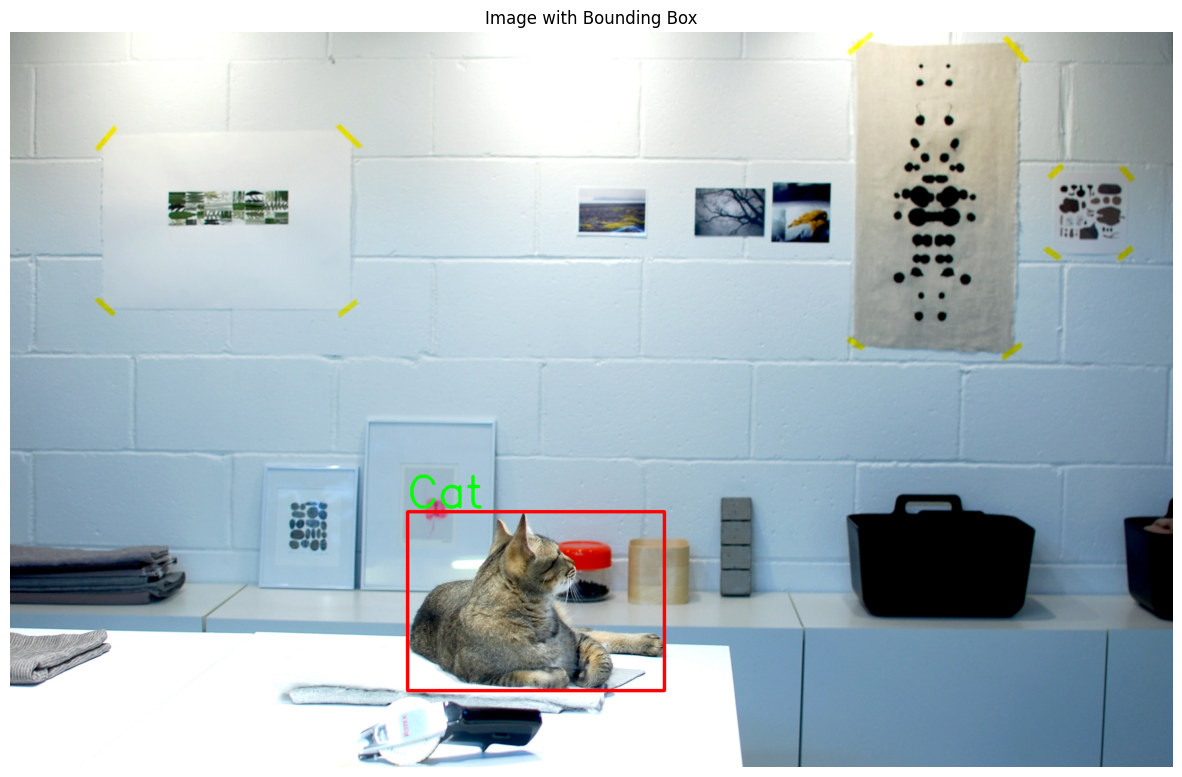

Image: (1148, 1722, 3)
Coordinates: (222, 149), (1530, 1068)


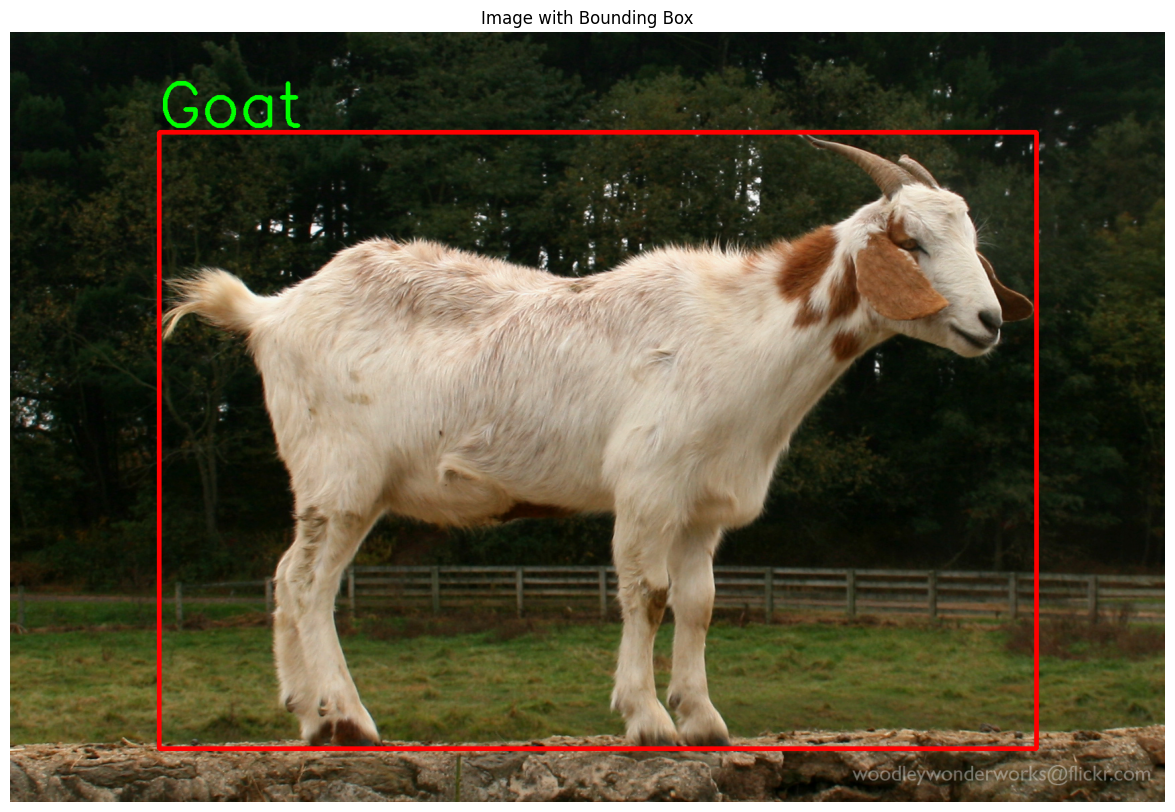

Image: (540, 720, 3)
Coordinates: (99, 50), (657, 432)


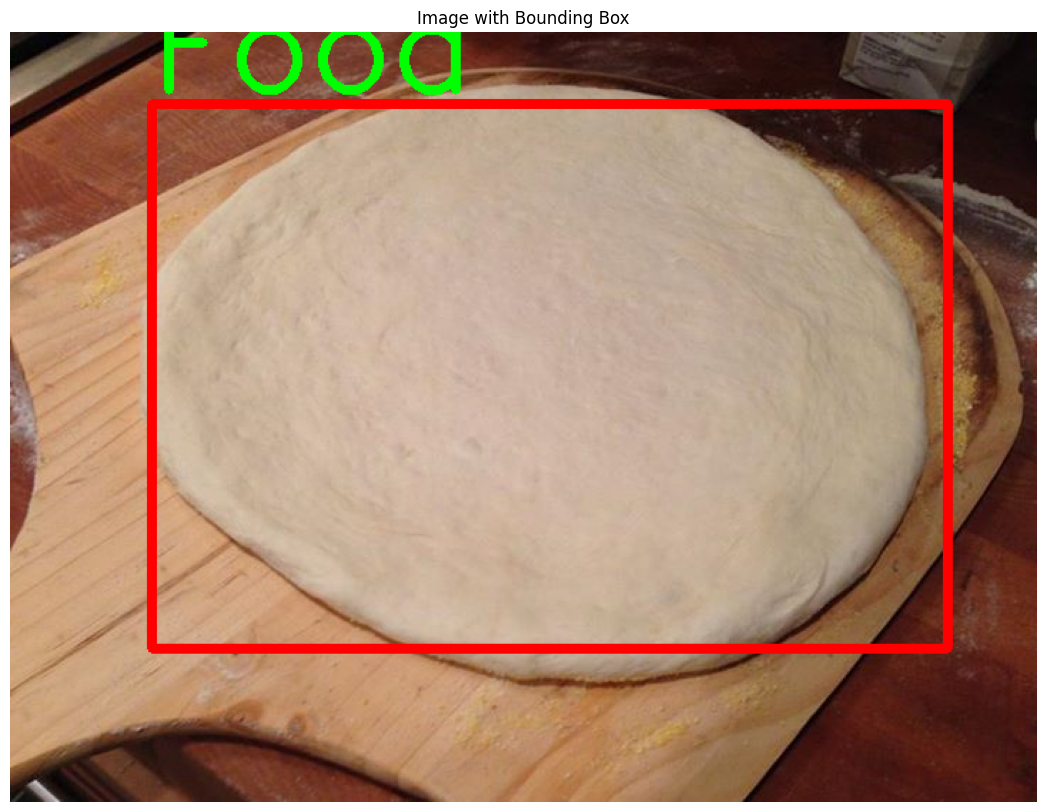

Image: (2448, 3264, 3)
Coordinates: (236, 683), (526, 1185)


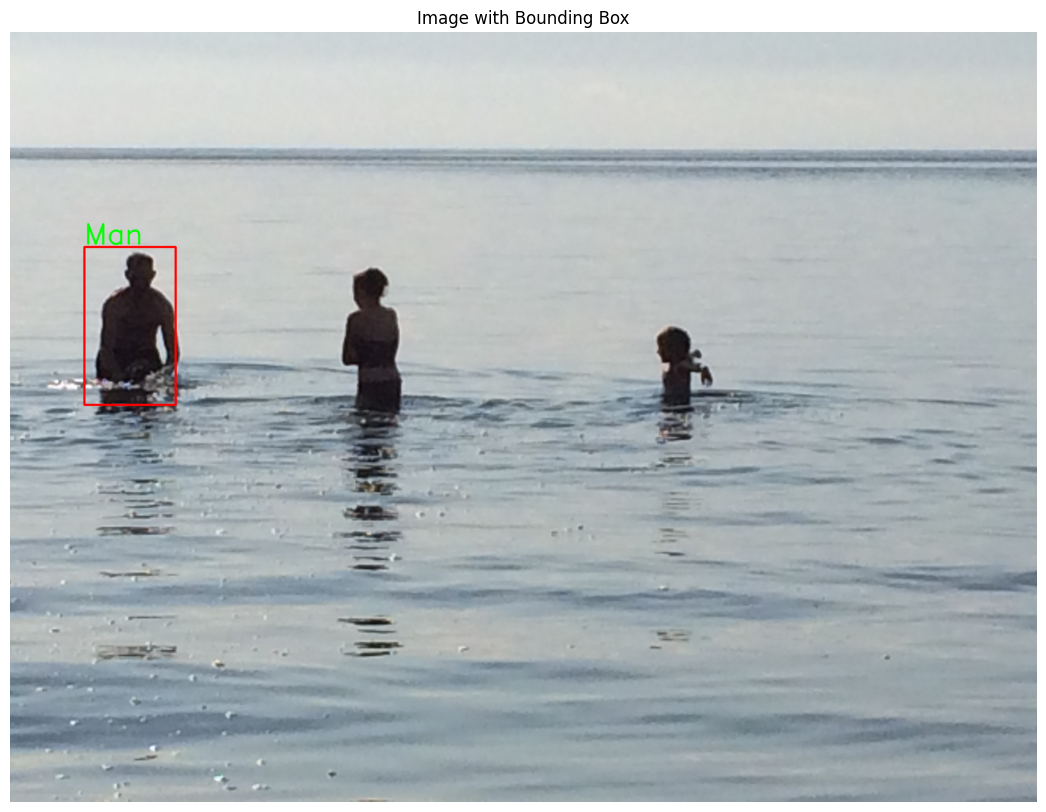

Image: (1200, 1600, 3)
Coordinates: (151, 105), (1469, 1085)


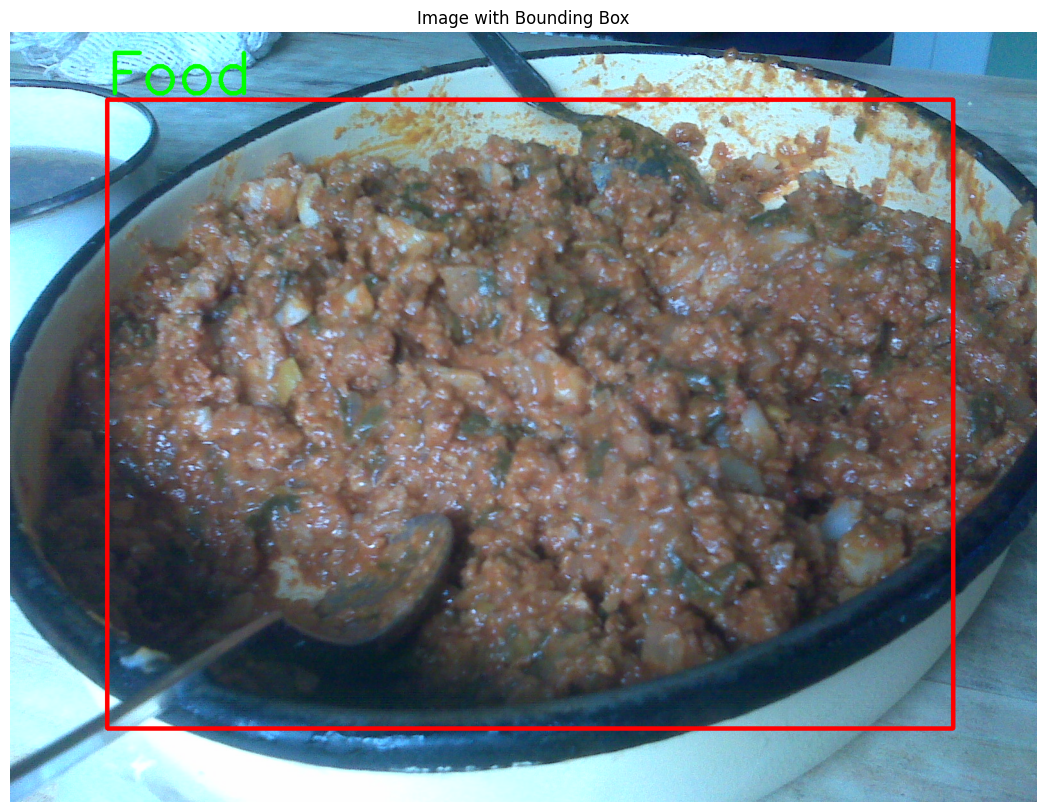

In [9]:
for img_id in random.sample(list(least_objects_img_ids), 5):
    plot_bbox(img_id)

### Get the required data from the dataset

In this project, the goal is to detect bottles. So we need the data related to this class. 

In [18]:
classes = ['Bottle']
class_descriptions.loc[class_descriptions[1].isin(['Bottle'])]

0       1
285  /m/04dr76w  Bottle

In [12]:
# Get the label name of the 'Bottle' class
bottle_pd = class_descriptions[class_descriptions[1]=='Bottle']
label_name_bottle = bottle_pd[0].values[0]

In [14]:
# Extract the bounding box coordinates for this class
bottle_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_bottle]
print('There are %d bottle objects in the dataset' %(len(bottle_bbox)))
bottle_img_id = bottle_bbox['ImageID']

There are 40188 bottle objects in the dataset


In [15]:
bottle_img_id = np.unique(bottle_img_id)
print('There are %d images containing at least one bottle' % (len(bottle_img_id)))

There are 11456 images containing at least one bottle


In [17]:
# We will train the model on 1500 random images between the images with at least one bottle
n = 1500
sub_bottle_img_id = random.sample(list(bottle_img_id), n)
sub_bottle_pd = images_boxable.loc[images_boxable['ImageID'].isin(sub_bottle_img_id)]
sub_bottle_pd.shape

(1500, 12)

In [22]:
sub_bottle_pd.head()

ImageID Subset  \
1134  270abd708e74e23d  train   
1817  4473de2c726be207  train   
2484  c70c6b49c9c32ed6  train   
2577  4395b62b9376feab  train   
2738  5e57aedcb2922774  train   

                                            OriginalURL  \
1134  https://c6.staticflickr.com/3/2585/3879312873_...   
1817  https://farm8.staticflickr.com/8242/8458769210...   
2484  https://farm7.staticflickr.com/69/159145668_39...   
2577  https://c4.staticflickr.com/2/1148/1326673259_...   
2738  https://farm5.staticflickr.com/3137/2770785223...   

                                     OriginalLandingURL  \
1134     https://www.flickr.com/photos/cbnsp/3879312873   
1817  https://www.flickr.com/photos/91108013@N02/845...   
2484  https://www.flickr.com/photos/maveric2003/1591...   
2577  https://www.flickr.com/photos/79112603@N00/132...   
2738  https://www.flickr.com/photos/benhanbury/27707...   

                                           License  \
1134  https://creativecommons.org/licenses/by/2.0/   
1817  https://creativecommons.org/licenses/by/2.0/   
2484  https://creativecommons.org/licenses/by/2.0/   
2577  https://creativecommons.org/licenses/by/2.0/   
2738  https://creativecommons.org/licenses/by/2.0/   

                                 AuthorProfileURL       Author  \
1134         https://www.flickr.com/people/cbnsp/  Milton Jung   
1817  https://www.flickr.com/people/91108013@N02/       Renate   
2484   https://www.flickr.com/people/maveric2003/    Eric Chan   
2577  https://www.flickr.com/people/79112603@N00/  Brian Mount   
2738    https://www.flickr.com/people/benhanbury/  Ben Hanbury   

                               Title  OriginalSize               OriginalMD5  \
1134  Restos do passeio de bicicleta        627646  JvM8Sly32LPDSCEvTLPa8w==   
1817            Alcohol in neurology        530818  0ZZyh1tpqyZcEr0DJCYMbg==   
2484    Ijeoma goes to the ball game        543922  LlkkxhuBNprGE44ylmNccQ==   
2577                    DSC00349.JPG        510100  d9TFRLT/SvZ2RSYez9ObNw==   
2738       Battle without Honour - 4       2818160  NGIRi0meLZrdw/TgWJZ0jQ==   

                                       Thumbnail300KURL  Rotation  
1134  https://c5.staticflickr.com/3/2585/3879312873_...       0.0  
1817  https://c2.staticflickr.com/9/8242/8458769210_...       0.0  
2484  https://c7.staticflickr.com/1/69/159145668_393...       0.0  
2577  https://c6.staticflickr.com/2/1148/1326673259_...       0.0  
2738  https://c3.staticflickr.com/4/3137/2770785223_...       0.0

In [19]:
# Select ImageID and OriginalURL columns, set ImageID as index.
# The keys of the dictionary are ImageIDs and the values are URLs
sub_bottle_dict = sub_bottle_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()
mappings = [sub_bottle_dict]

### Download images

In [29]:
for idx, obj_type in enumerate(classes):
  n_issues = 0
  # create the directory
  if not os.path.exists(obj_type):
    os.mkdir(obj_type)
  for img_id, url in mappings[idx].items():
    try:
      img = io.imread(url)
      saved_path = os.path.join(obj_type, img_id+".jpg")
      io.imsave(saved_path, img)
    except Exception as e:
      n_issues += 1
  print(f"Images Issues: {n_issues}")

C:\ProgramData\anaconda3\envs\fastervgg\lib\site-packages\PIL\TiffImagePlugin.py:648: UserWarning: Metadata Warning, tag 33723 had too many entries: 6, expected 1
  warnings.warn(


Images Issues: 185


### Save bottle images 
we use 80% of the images for training and 20% for test 

In [36]:
train_path = './data/images/train'
test_path = './data/images/test'

random.seed(1)
for i in range(len(classes)):
    all_imgs = os.listdir(classes[i])
    all_imgs = [f for f in all_imgs if not f.startswith('.')]
    random.shuffle(all_imgs)
    
    limit = int(n * 0.8)  # n = 1500

    train_imgs = all_imgs[:limit]
    test_imgs = all_imgs[limit:]
    
    for j in range(len(train_imgs)):
        original_path = os.path.join(classes[i], train_imgs[j])
        new_path = os.path.join(train_path, train_imgs[j])
        copyfile(original_path, new_path)
    
    for j in range(len(test_imgs)):
        original_path = os.path.join(classes[i], test_imgs[j])
        new_path = os.path.join(test_path, test_imgs[j])
        copyfile(original_path, new_path)

 ### Acceptable data format for Faster R-CNN model:

#### (fname_path, xmin, xmax, ymin, ymax, class_name)
The data will be gathered in 'train_df' and 'test_df' data frames with respect to this format

In [ ]:
label_names = [label_name_bottle]

train_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])
train_imgs = os.listdir(train_path)
train_imgs = [name for name in train_imgs if not name.startswith('.')]

for i in range(len(train_imgs)):
    sys.stdout.write('Parse train_imgs ' + str(i) + '; Number of boxes: ' + str(len(train_df)) + '\r')
    sys.stdout.flush()
    img_name = train_imgs[i]
    img_id = img_name[0:16]
    tmp_df = annotations_bbox[annotations_bbox['ImageID']==img_id]
    for index, row in tmp_df.iterrows():
        labelName = row['LabelName']
        for i in range(len(label_names)):
            if labelName == label_names[i]:
                new_row = pd.DataFrame({'FileName': [img_name], 
                        'XMin': [row['XMin']], 
                        'XMax': [row['XMax']], 
                        'YMin': [row['YMin']], 
                        'YMax': [row['YMax']], 
                        'ClassName': [classes[i]]})
                train_df = pd.concat([train_df, new_row], ignore_index=True)

In [31]:
train_df.head()

FileName      XMin      XMax      YMin      YMax ClassName
0  0026652e5ce138ff.jpg  0.043750  0.173750  0.000000  0.462500    Bottle
1  00326537f57449d0.jpg  0.035948  0.985294  0.000000  0.998366    Bottle
2  00381fffa680d9fc.jpg  0.057000  0.095000  0.704648  0.952024    Bottle
3  00381fffa680d9fc.jpg  0.600000  0.640000  0.677661  0.898051    Bottle
4  00381fffa680d9fc.jpg  0.699000  0.745000  0.685157  0.913043    Bottle

In [32]:
train_df.shape

(4585, 6)

In [40]:
test_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

# find boxes in each image and put them in a dataframe
test_imgs = os.listdir(test_path)
test_imgs = [name for name in test_imgs if not name.startswith('.')]

for i in range(len(test_imgs)):
    sys.stdout.write('Parse test_imgs ' + str(i) + '; Number of boxes: ' + str(len(test_df)) + '\r')
    sys.stdout.flush()
    img_name = test_imgs[i]
    img_id = img_name[0:16]
    tmp_df = annotations_bbox[annotations_bbox['ImageID']==img_id]
    for index, row in tmp_df.iterrows():
        labelName = row['LabelName']
        for i in range(len(label_names)):
            if labelName == label_names[i]:
                new_row = pd.DataFrame({'FileName': [img_name], 
                      'XMin': [row['XMin']], 
                      'XMax': [row['XMax']], 
                      'YMin': [row['YMin']], 
                      'YMax': [row['YMax']],
                      'ClassName': [classes[i]]})
                test_df  = pd.concat([test_df , new_row], ignore_index=True)                                                             

In [41]:
# Save the data frames as csv files
train_df.to_csv('./data/CSVs/train.csv')
test_df.to_csv('./data/CSVs/test.csv')

#### Save train and test csv files as text files (into annotation.txt and  test_annotation.txt)
#### These files then will be used to train (and test) the model

In [47]:
train_df = pd.read_csv('./data/CSVs/train.csv')

with open("./data/annotations/annotation.txt", "w+") as f:
    for idx, row in train_df.iterrows():
        img_path = 'data/images/train/' + row['FileName']
        img = cv2.imread(img_path)
        
        if img is None:  # Check if the image was successfully read
            print(f"Failed to read image at {img_path}. Skipping...")
            continue

        height, width = img.shape[:2]
        x1 = int(row['XMin'] * width)
        x2 = int(row['XMax'] * width)
        y1 = int(row['YMin'] * height)
        y2 = int(row['YMax'] * height)
        
        file_path = 'data/images/train/'
        fileName = os.path.join(file_path, row['FileName'])
        className = row['ClassName']
        f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')


Failed to read image at train/4dc70decc16ef163.jpg. Skipping...


In [60]:
test_df = pd.read_csv('./data/CSVs/test.csv')

# for test
with open("./data/annotations/test_annotation.txt", "w+") as f:
    for idx, row in test_df.iterrows():
        sys.stdout.write(str(idx) + '\r')
        sys.stdout.flush()
        img = cv2.imread('data/images/test/' + row['FileName'])
        
        if img is None:  # Check if the image was successfully read
            print(f"Failed to read image at {img_path}. Skipping...")
            continue
        
        height, width = img.shape[:2]
        x1 = int(row['XMin'] * width)
        x2 = int(row['XMax'] * width)
        y1 = int(row['YMin'] * height)
        y2 = int(row['YMax'] * height)
      
        file_path = 'data/images/test/'
        fileName = os.path.join(file_path, row['FileName'])
        className = row['ClassName']
        f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')